# Preprocessing The Data

#### Finding Number of images in Each Set
Lets check how many images we have for each class in train and test sets.

#### Normalization

In order to speedup the training time we can devide the image matrices by 255 to map them to the range of [0,1].

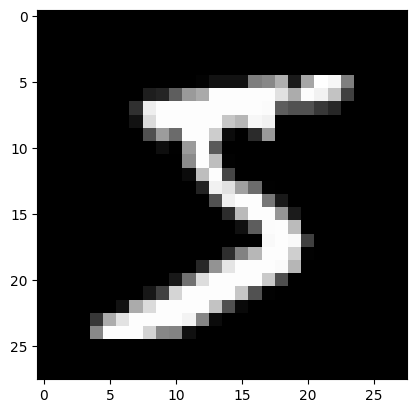

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing, metrics
from tqdm import tqdm


# A function to plot images
def show_image(img):
    image = img.reshape((28, 28))
    plt.imshow(image, 'gray')

np.random.seed(0)

# Reading The Train Set
train_images_file = open('train-images.idx3-ubyte', 'rb')
train_images_file.seek(4)
num_of_train_images = int.from_bytes(train_images_file.read(4), 'big')
train_images_file.seek(16)

train_labels_file = open('train-labels.idx1-ubyte', 'rb')
train_labels_file.seek(8)

train_images, train_labels = [], []
for n in range(num_of_train_images):
    image = np.zeros((784, 1))
    for i in range(784):
        image[i, 0] = int.from_bytes(train_images_file.read(1), 'big') / 256
    image = np.array(image).reshape((28, 28, 1))
    train_images.append(image)
    label_value = int.from_bytes(train_labels_file.read(1), 'big')
    label = np.zeros((10, 1))
    label[label_value, 0] = 1
    train_labels.append(label)
    
    # train_set.append((aimage, label))


# Reading The Test Set
test_images_file = open('t10k-images.idx3-ubyte', 'rb')
test_images_file.seek(4)

test_labels_file = open('t10k-labels.idx1-ubyte', 'rb')
test_labels_file.seek(8)

num_of_test_images = int.from_bytes(test_images_file.read(4), 'big')
test_images_file.seek(16)

test_images, test_labels = [], []
for n in range(num_of_test_images):
    image = np.zeros((784, 1))
    for i in range(784):
        image[i] = int.from_bytes(test_images_file.read(1), 'big') / 256
    image = np.array(image).reshape((28, 28, 1))
    test_images.append(image)
    label_value = int.from_bytes(test_labels_file.read(1), 'big')
    label = np.zeros((10, 1))
    label[label_value, 0] = 1
    test_labels.append(label)


# Plotting an image
show_image(train_images[0])
plt.show()

## Convert to numpy array
As we need numpy array to implement LeNet-5 using numpy, we need to transfer array lists to numpy array

In [68]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

## Shuffle the Image and Labels Matrices

We should write a shuffle function to perform it on the data because we need it later in backpropagation process.

In [69]:
from sklearn.utils import shuffle
import time

def shuffle_together(x, y):
  return shuffle(x, y, random_state=int(time.time()))

train_images, train_labels = shuffle_together(train_images, train_labels)
test_images, test_labels = shuffle_together(test_images, test_labels)
# train_images = train_images.reshape((train_images.shape[0], train_images.shape[1]))
# test_images = test_images.reshape((test_images.shape[0], test_images.shape[1]))
train_labels = train_labels.reshape((train_labels.shape[0], train_labels.shape[1]))
test_labels = test_labels.reshape((test_labels.shape[0], test_labels.shape[1]))

assert train_images.shape == (60000, 28, 28, 1)
assert train_labels.shape == (60000, 10)
assert test_images.shape == (10000, 28, 28, 1)
assert test_labels.shape == (10000, 10)

print("\033[92m All tests passed.")

 All tests passed.


# Implementing Convolutional Neural Network (CNN)
LeNet-5 Architecture
1. Input Layer
    * Input Size: 32 × 32 grayscale image (1 channel)
2. C1 - First Convolutional Layer
    * Number of Filters: 6
    * Filter Size: 5 × 5
    * Stride: 1
    * Padding: 2 (to maintain the input size as 32 × 32)
    * Output Size: 28 × 28 × 6 (28 x 28 spatial dimensions with 6 channels)
3. S2 - First Subsampling (Pooling) Layer
    * Type: Average Pooling
    * Filter Size: 2 × 2
    * Stride: 2
    * Output Size: 14 × 14 ×6
4. C3 - Second Convolutional Layer
    * Number of Filters: 16
    * Filter Size: 5 × 5
    * Stride: 1
    * Padding: 0
    * Output Size: 10 × 10 × 16
5. S4 - Second Subsampling (Pooling) Layer
    * Type: Average Pooling
    * Filter Size: 2 × 2
    * Stride: 2
    * Output Size: 5 × 5 × 16
6. C5 - Third Convolutional Layer
    * Number of Filters: 120
    * Filter Size: 5 × 5
    * Stride: 1
    * Padding: 0
    * Output Size: 1 × 1 × 120
7. F6 - Fully Connected Layer
    * Number of Neurons: 84
    * Activation: Relu Or Tanh
8. Output Layer
    * Number of Neurons: 10 (for digit classification from 0 to 9)
    * Activation: Softmax or Sigmoid

## Conv layer
At first, I implement Conv layer's forward and backward prop

In [70]:
class Conv():
    weight = None
    bias = None
    nc = None
    nc_prev = None
    filter_size = None
    stride = None
    pad = None
    learn_rate = None
    img = None

    def __init__(self, nc = 0, filter_size = 0, stride = 1, pad = 0, learn_rate = 0.01, nc_prev = 1):
        self.nc = nc
        self.filter_size = filter_size
        self.bias = np.random.randn(1, 1, 1, nc) * (1 / 1500)
        self.weight = np.random.randn(filter_size, filter_size, nc_prev, nc) * (nc_prev / 1500)
        self.stride = stride
        self.pad = pad
        self.learn_rate = learn_rate
        self.nc_prev = nc_prev

    def forward(self, img):
        
        self.img = np.pad(img,((0,0),(self.pad,self.pad),(self.pad,self.pad),(0,0)))
        
        (layer, nh_prev, nw_prev, nc_prev) = img.shape
        # print(f'weight shape = {self.weight.shape}, bias shape = {self.bias.shape}')
        # print("====================================")

        nh = int((nh_prev + 2 * self.pad - self.filter_size) / self.stride) + 1
        nw = int((nw_prev + 2 * self.pad - self.filter_size) / self.stride) + 1

        Z = np.zeros((layer, nh, nw, self.nc))\

        for i in range(layer):
            current_img = self.img[i]
            for h in range(nh):
                vertical_start = self.stride * h
                vertical_end = vertical_start + self.filter_size
                for w in range(nw):
                    horizontal_start = self.stride * w
                    horizontal_end = horizontal_start + self.filter_size
                    for c in range(self.nc):
                        slice_of_img = current_img[vertical_start:vertical_end, horizontal_start:horizontal_end, :]
                        weights = self.weight[:, :, :, c]
                        biases = self.bias[:, :, :, c]
                        z = np.multiply(slice_of_img, weights)
                        z = np.sum(z)
                        biases = np.squeeze(biases)
                        z += biases
                        # print(f'image shape: {slice_of_img.shape}, weight shape: {weights.shape}, bias = {biases}, bias shape: {biases.shape}, z = {z} ,z shape: {z.shape}')
                        Z[i, h, w, c] = z
        return Z
    
    def backward(self, dZ):
        # print(f'pad = {self.pad}')
        (layer, nh, nw, nc) = dZ.shape
        dimg = np.zeros(self.img.shape)
        dweight = np.zeros(self.weight.shape)
        dbias = np.zeros(self.bias.shape)

        img_pad = np.pad(self.img, ((0, 0), (self.pad, self.pad), (self.pad, self.pad), (0, 0)))
        dimg_pad = np.pad(dimg, ((0, 0), (self.pad, self.pad), (self.pad, self.pad), (0, 0)))
        for i in range(layer):
            current_img_pad = img_pad[i]
            current_dimg_pad = dimg_pad[i]
            for h in range(nh):
                for w in range(nw):
                    for c in range(nc):
                        vertical_start = self.stride * h
                        vertical_end = vertical_start + self.filter_size
                        horizontal_start = self.stride * w
                        horizontal_end = horizontal_start + self.filter_size

                        slice_of_img = current_img_pad[vertical_start:vertical_end, horizontal_start:horizontal_end, :]
                        
                        current_dimg_pad[vertical_start:vertical_end, horizontal_start:horizontal_end, :] += self.weight[:,:,:,c] * dZ[i, h, w, c]
                        dweight[:,:,:,c] += slice_of_img * dZ[i, h, w, c] * self.learn_rate
                        dbias[:,:,:,c] += dZ[i, h, w, c] * self.learn_rate
            print(f'dimg_pad shape = {current_dimg_pad[self.pad:-self.pad, self.pad:-self.pad, :].shape}, dimag shape = {dimg[i, :, :, :].shape}')
            dimg[i, :, :, :] = current_dimg_pad[self.pad:-self.pad, self.pad:-self.pad, :]
        
        self.weight -= dweight * self.learn_rate
        self.bias -= dbias * self.learn_rate
        return dimg

## Pooling layer
Now, it's time to implement pooling layer

You should give every implementations

nc = number of channels

you should give your ordered mode (max pooling or average pooling)

In [71]:
class Pool():
    stride = None
    filter_size = None
    nc = None
    img = None
    pad = None
    mode = None

    def __init__(self, stride = 1, filter_size = 0, nc = 1, pad = 0, mode = "max"):
        self.stride = stride
        self.filter_size = filter_size
        self.nc = nc
        self.pad = pad
        self.mode = mode.lower()

    def forward(self, img):
        
        self.img = img
        
        (layer, nh_prev, nw_prev, nc_prev) = img.shape

        nh = int((nh_prev + 2 * self.pad - self.filter_size) / self.stride) + 1
        nw = int((nw_prev + 2 * self.pad - self.filter_size) / self.stride) + 1

        Z = np.zeros((layer, nh, nw, self.nc))

        for i in range(layer):
            current_img = img[i]
            for h in range(nh):
                vertical_start = self.stride * h
                vertical_end = vertical_start + self.filter_size
                for w in range(nw):
                    horizontal_start = self.stride * w
                    horizontal_end = horizontal_start + self.filter_size
                    for c in range(self.nc):
                        slice_of_img = current_img[vertical_start:vertical_end, horizontal_start:horizontal_end, :]
                        if self.mode == 'avrage':
                            Z[i, h, w, c] = np.mean(slice_of_img)
                        else:
                            Z[i, h, w, c] = np.max(slice_of_img)

        return Z
    
    def backward(self, dz):
        (layer, nh, nw, nc) = dz.shape
        dimg = np.zeros(self.img.shape)
        for i in range(layer):
            current_img = self.img[i]
            for h in range(nh):
                vertical_start = self.stride * h
                vertical_end = vertical_start + self.filter_size
                for w in range(nw):
                    horizontal_start = self.stride * w
                    horizontal_end = horizontal_start + self.filter_size
                    for c in range(nc):
                        slice_of_img = current_img[vertical_start:vertical_end, horizontal_start:horizontal_end, :]
                        if self.mode == 'avrage':
                            dimg[i, vertical_start:vertical_end, horizontal_start:horizontal_end, :] += dz[i, h, w, c] / np.prod((self.filter_size, self.filter_size))
                        else:
                            mask = slice_of_img == np.max(slice_of_img)
                            dimg[i, vertical_start:vertical_end, horizontal_start:horizontal_end, :] += mask * dz[i, h, w, c]
        return dimg

## Fully Connected layes
Here we implemented fully connected layer

neurons = number of neurons in this layer

weights and bias will implement automatically

In [72]:
class FC():

    neurons = None
    inputNeurons = None
    weights = None
    bias = None
    learn_rate = None
    img = None
    def __init__(self, learn_rate = 0.01, neurons = 1, inputNeurons = 1) -> None:
        self.neurons = neurons
        self.learn_rate = learn_rate
        self.weights = np.random.randn(inputNeurons, neurons) * (1 / 1500)
        self.bias = np.zeros(neurons)
        self.inputNeurons = inputNeurons

    def forward(self, img):
        self.img = img
        # print(f'img shape: {img.shape}, weights shape: {self.weights.shape}, bias shape: {self.bias.shape}')
        Z = self.img @ self.weights + self.bias
        return Z
    
    def backward(self, dz):
        dimg = dz @ self.weights.T
        dw = self.img.T @ dz
        # print(f'weight shape: {self.weights.shape}, dw shape: {dw.shape}, img shape: {self.img.shape}, dz shape: {dz.shape}')
        self.weights -= dw * self.learn_rate
        self.bias -= np.sum(dz, axis=0) * self.learn_rate
        return dimg

In [73]:
class Flatten():
    cache_X = None

    def forward(self, X):
        # X is of shape (batch_size, height, width, in_nchannel)
        # output is of shape (batch_size, -1)
        self.cache_X = X
        return X.reshape((len(X), -1))

    def backward(self, grad_in):
        return grad_in.reshape(self.cache_X.shape)

In [74]:
class ReLU():

    cache_X = None
    def forward(self, X):
        self.cache_X = X
        return np.maximum(X, 0)

    def backward(self, grad_in):
        dX = grad_in.copy()
        dX[self.cache_X <= 0] = 0
        return dX

In [75]:
class Sigmoid():

    chache_X = None
    def forward(self, X):
        self.chache_X = X
        return 1 / (1 + np.exp(-X))
    def backward(self, grad, X = None):
    
        s = 1/(1+np.exp(-self.chache_X))
        dX = grad * s * (1-s)
        return dX

In [76]:
class Tanh():

    cached_X = None
    def forward(self, x):
        self.cached_X = np.tanh(x)
        return self.cached_X
    
    def backward(self, dout, X = None):
        # Derivative of tanh is 1 - tanh^2(x)
        dinput = dout * (1 - self.cached_X ** 2)
        return dinput

In [77]:
def softmax(X):
    # print(f'type X = {type(X)}')
    e_x = np.exp(X - np.max(X, axis=-1, keepdims=True))
    probs = e_x / e_x.sum(axis=-1, keepdims=True)
        # return preprocessing.normalize(probs + epsilon, norm='l1')
    return probs

class Softmax():

    cache_grad = None
    cache_X = None
    
    def forward(self, X, y):
        # X, y and y_hat are of shape (batch_size, in_dim)
        self.cache_X = X
        m = len(X)
        # print(f'type X: {type(X)}')
        y_hat = softmax(X)
        loss = (-1 / m) * np.log(y_hat[y == 1]).sum()
        self.cache_grad = (y_hat - y) / m
        return y_hat, loss

    def backward(self, grad):
        # print(self.cache_grad, self.cache_X)
        return self.cache_grad

In [78]:
class Model():

    layers = []

    def implementConv(self,  nc = 0, filter_size = 0, stride = 1, pad = 0, learn_rate = 0.01, nc_prev = 1):
        self.layers.append(Conv(nc=nc, filter_size=filter_size, stride=stride, pad=pad, learn_rate=learn_rate, nc_prev=nc_prev))
    
    def implementPooling(self, stride = 1, filter_size = 0, nc = 1, pad = 0, mode = "max"):
        self.layers.append(Pool(stride, filter_size, nc, pad, mode))

    def implementFullyConnected(self, learn_rate = 0.01, neurons = 1, inputNeurons = 1):
        self.layers.append(FC(learn_rate, neurons, inputNeurons))

    def setFlatten(self):
        self.layers.append(Flatten())

    def setRelu(self):
        self.layers.append(ReLU())

    def setTanh(self):
        self.layers.append(Tanh())
    
    def setSigmoid(self):
        self.layers.append(Sigmoid())

    def setSoftmax(self):
        self.layers.append(Softmax())

    def forward(self, X, Y = None):
        for layer in self.layers[: -1]:
            X = layer.forward(X)
        y_hat, loss = self.layers[-1].forward(X, Y)
        return y_hat, loss
    
    def backward(self):
        grad = 1
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
        return grad
    
    def fit(self, X_train, y_train, X_validate, y_validate, epochs=1, batch_size=32):
        n_sample = len(X_train)
        n_batch = (n_sample - 1) // batch_size + 1
        y_pred = np.zeros_like(y_train)
        for epoch in range(epochs):
            print(f"Epoch {epoch+1} ================")
            with tqdm(total = n_batch) as t:
                tot_loss = tot_acc = 0
                for i in range(n_batch):
                    batch = range(batch_size * i, min(batch_size * (i + 1), n_sample))
                    y_hat, loss = self.forward(X_train[batch], y_train[batch])
                    acc = (1 / len(batch)) * np.sum(np.argmax(y_hat) == np.argmax(y_train[batch]))
                    y_pred[batch] = y_hat
                    grad = self.backward()
                    tot_loss += loss
                    tot_acc += acc
                    if (i + 1) % 32 == 0 or i + 1 == n_batch:
                        t.set_postfix({
                            'avg_loss': tot_loss / (i + 1),
                            'avg_accuracy': tot_acc / (i + 1),
                            'max_abs_gradient': np.max(abs(grad))
                        })
                        cur_n_batch = i % 32 + 1
                        t.update(cur_n_batch)
            print("Validation:")
            val_y_hat, val_loss = self.evaluate(X_validate, y_validate)
            print('loss: ', val_loss)
            print(
                metrics.classification_report(np.argmax(val_y_hat, axis=-1),
                                              np.argmax(y_validate)))
            
    def predict(self, X, batch_size=32):
        y_pred = []
        n_sample = len(X)
        n_batch = (n_sample - 1) // batch_size + 1
        for i in tqdm(range(n_batch)):
            batch = range(batch_size * i, min(batch_size * (i + 1), n_sample))
            y_hat = self.forward(X[batch])
            y_pred.append(y_hat)
        return np.concatenate(y_pred)

    def evaluate(self, X, y, batch_size=32):
        y_pred = []
        n_sample = len(X)
        n_batch = (n_sample - 1) // batch_size + 1
        tot_loss = 0
        for i in tqdm(range(n_batch)):
            batch = range(batch_size * i, min(batch_size * (i + 1), n_sample))
            y_hat, loss = self.forward(X[batch], y[batch])
            y_pred.append(y_hat)
            tot_loss += loss
        return np.concatenate(y_pred), tot_loss / n_batch

    def get_weights(self):
        weights = []
        for layer in self.layers:
            if hasattr(layer, 'W'):
                weights.append(layer.W)
            if hasattr(layer, 'b'):
                weights.append(layer.b)
        return weights

    def set_weights(self, weights):
        # careful of not copying by reference
        weight_iter = iter(weights)
        for layer in self.layers:
            if hasattr(layer, 'W'):
                layer.W = np.array(next(weight_iter))
            if hasattr(layer, 'b'):
                layer.b = np.array(next(weight_iter))


In [79]:
learn_rate = 0.02
model = Model()
model.implementConv(nc=6, filter_size=5, learn_rate=learn_rate, pad=2)
model.implementPooling(nc=6, filter_size=2, stride=2)
model.implementConv(nc=16, nc_prev=6, filter_size=5, learn_rate=learn_rate)
model.implementPooling(nc=16, filter_size=2, stride=2)
model.implementConv(nc=120, filter_size=5, nc_prev=16, learn_rate=learn_rate)
model.setFlatten()
model.implementFullyConnected(neurons=84, learn_rate=learn_rate, inputNeurons=120)
model.setRelu()
model.implementFullyConnected(neurons=10, learn_rate=learn_rate, inputNeurons=84)
model.setSoftmax()
model.fit(train_images, train_labels, test_images, test_labels, epochs=10)

Epoch 1 ================


  0%|          | 0/1875 [00:00<?, ?it/s]

dimg_pad shape = (0, 0, 16), dimag shape = (5, 5, 16)


ValueError: could not broadcast input array from shape (0,0,16) into shape (5,5,16)

2
2
3
3
